<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# 5. Fishing for Correlations at Sea
Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are four considerations:

1. __Persistence__, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel).
1. __Time irregularities__, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
1. __Age uncertainties__, for example comparing two records, each with an ensemble of plausible chronologies (generated, for instance, by a Bayesian age model)
1. __Test multiplicity__ aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

Accordingly,  Pyleoclim facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results. We start by loading a few useful packages:

In [1]:
import matplotlib.pyplot as plt    
import pyleoclim as pyleo
pyleo.set_style('web')  # set the visual style
import numpy as np
import xarray as xr

In [2]:
# Note: JEG had to use this to silence warnings with xarray 0.16.1, as 0.19.1 is no longer available from conda-forge
import warnings
warnings.filterwarnings('ignore')

## A case study from Crystal Cave
In this notebook we reproduce the case of [Hu et al, 2017](http://dx.doi.org/10.1016/j.epsl.2016.11.048), particularly the example of their section 4, which illustrates several of these pitfalls at once. The example illuminates the issue of relying too strongly on correlations between a paleoclimate record and an instrumental field to interpret the record. Before we start, a disclaimer: the studies investigated in this paper are by no means isolated cases. They just happened to be cases that we knew about, and thought deserved a second look in light of more rigorous statistics. The same study could have been written by subsituting any number of other records interpreted, wholly or in part, on the basis of correlations. Accordingly, what follows should not be viewed as an indictment of a particularly study or group of authors, rather, at how easy it is by the best-intentioned scientists to get fooled by spurious correlations, and (thankfully), how easy we've made it not get similarly fooled by carrying out this analysis with `pyleoclim`. 


### The Crystal Cave record

The example uses the speleothem record of [McCabe-Glynn et al , 2013](https://www.nature.com/articles/ngeo1862) from Crystal Cave, California, in the Sequoia National Forest.  Of interest to us is the $\delta^{18}O$ record, which the authors interepret as reflecting sea-surface temperatures (SST) in the Kuroshio Extension region of the West Pacific. This is a strong claim, given that no mechanistic link is proposed,  and relies entirely on an analysis of correlations between the record and instrumental SST.  

We first load and plot this record:

In [3]:
d = pyleo.Lipd('../data/Crystal.McCabe-Glynn.2013.lpd')
cc = d.to_LipdSeries(2)   

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting paleoData...
extracting: Crystal.McCabe-Glynn.2013
Created time series: 3 entries


Let's do a quick plot to check that we have what we want:

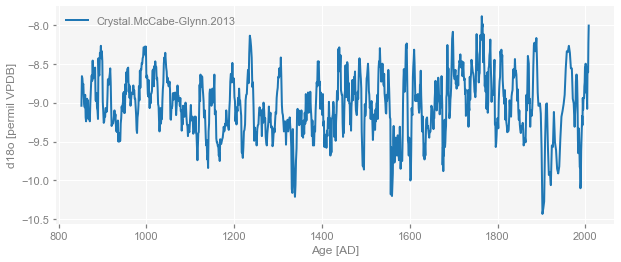

In [4]:
fig, ax = cc.plot()

Notice how the code harvested the correct metadata from the LiPD file. If everything is in its right place, it makes it easy to exploit that information. If you're feeling more frisky, you can even ask for a whole dashboard, including a spectrum:

Performing spectral analysis on individual series: 100%|█████████████████████████████████| 200/200 [00:26<00:00,  7.64it/s]


(<Figure size 792x576 with 4 Axes>,
 {'ts': <AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>,
  'dts': <AxesSubplot:xlabel='PDF'>,
  'map': <GeoAxesSubplot:>,
  'spec': <AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>})

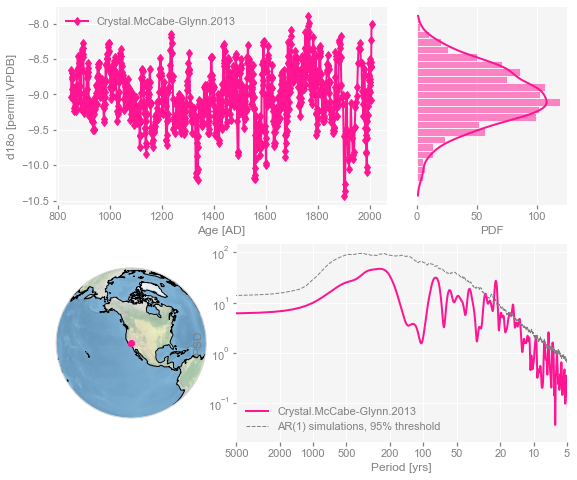

In [5]:
cc.dashboard(metadata=False)

This is a very high resolution record, with near-annual spacing (check it), and a broadly red spectrum that exhibits a number of spectral peaks at interannual and decadal scales.


### SST data

The original paper correlated the above record against the Kaplan SST dataset.  In this notebook we instead use the [HadSST4 dataset](https://www.metoffice.gov.uk/hadobs/hadsst4/index.html),  which is more up to date, and which we first download via `wget`. (~8Mb)

In [6]:
!wget https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc
!mv HadSST.4.0.1.0_median.nc ../data

--2022-06-01 19:48:01--  https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 23.45.43.110
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|23.45.43.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8772375 (8.4M) [application/x-netcdf]
Saving to: ‘HadSST.4.0.1.0_median.nc’

HadSST.4.0.1.0_medi 100%[===================>]   8.37M  4.60MB/s    in 1.8s    

2022-06-01 19:48:03 (4.60 MB/s) - ‘HadSST.4.0.1.0_median.nc’ saved [8772375/8772375]



Next we load it via the excellent `xarray` package.

In [7]:
ds = xr.open_dataset('../data/HadSST.4.0.1.0_median.nc')
print(ds)

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7


As an example, let's only consider the Northern Hemisphere Pacific Ocean. For practicality, let's first adjust the coordinate system so that longitude is expressed from 0 to 360 degrees instead of 180W to 180E:

In [8]:
ds_rolled = ds.assign_coords(longitude=(ds.longitude % 360)).roll(longitude=(ds.dims['longitude'] // 2))
ds_rolled

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan nan nan ... nan nan
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 0.0 5.0 5.0 10.0 ... -5.0 -5.0 0.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

Now let's select the needed data:

In [9]:
ds_sel = ds_rolled.sel(longitude=slice(120,280),latitude=slice(0,90))
ds_sel

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 18, longitude: 32, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 2.5 7.5 12.5 17.5 ... 72.5 77.5 82.5 87.5
  * longitude       (longitude) float64 122.5 127.5 132.5 ... 267.5 272.5 277.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan -0.19231786 ... nan
    time_bnds       (time, bnds) datetime64[ns] 1850-01-01 ... 2022-05-01
    latitude_bnds   (latitude, bnds) float64 0.0 5.0 5.0 10.0 ... 85.0 85.0 90.0
    longitude_bnds  (longitude, bnds) float64 120.0 125.0 125.0 ... -85.0 -80.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

## Pitfall #1: Persistence

Persistence is the tendency of many geophysical timeseries (particularly in paleoclimatology) to show some kind of memory: consecutive observations tend to resemble each other, resulting in timeseries that have fairly broad trends and low-frequency fluctuations, and comparatively little high-frequency fluctuations. 

This has an important consequence: the standard assumption of independence, which undergirds much of frequentist statistics, is violated in this case. In a timeseries with $n$ fully independent observations (e.g. white noise), the degrees of freedom for the variance are $DOF = n -1$  But if memory is present, this number can be drastically reduced. 

### Single location
Let us look at a random location and build some intuition. First, we need to compute montly anomalies and annualize them. `xarray` makes that easy (4 lines of code), so let's look at the result:

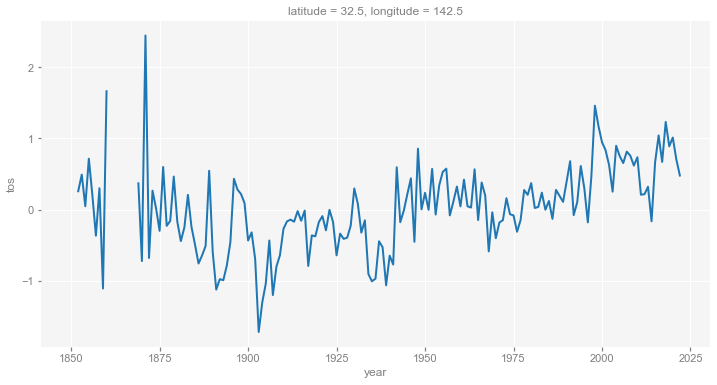

In [10]:
st = ds['tos'].sel(latitude=32.5, longitude = 142.5, method='nearest')  # 32.5N 142.5W near Kuroshio Extension
climatology = st.groupby("time.month").mean("time")
anomalies = st.groupby("time.month") - climatology
st_annual = anomalies.groupby("time.year").mean("time")
#f, ax = plt.subplots(figsize=()
st_annual.plot(figsize=[12, 6])

Notice the coverage gaps in the 1860s. This, and the fact that the Crystal Cave chronology is not uniformly spaced, would ordinarily make it challenging to compare the two series, requiring some form of interpolation or binning. Pyleoclim does all this for you under the hood.

To enjoy these benefits, however, let us turn the temperature data into a _Series_ object.

In [11]:
stts = pyleo.Series(time=st_annual.coords['year'].values,
                    time_unit ='year CE', 
                    value=st_annual.values,
                    value_unit = 'C')

Now we can compute correlations with the Crystal Cave record. 

In [12]:
corr_res = stts.correlation(cc)
print(corr_res.r)

0.32422714913422396


Quite a few things happened here. First, `pyleoclim` was smart enough to figure out a common timespan between the two records, and used linear interpolation to align the two timeseries on a common axis. It did all this under the hood without you having to lift a finger, but you could get your head in there and customize this process (e.g. choosing a different way to align the time axes) if you wanted it too.

Now, about the result: the correlation is $r=0.38$. Is it significant?

The standard way to assess this, is with a t-test using the test statistic: $$T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$ (embedded in countless computing packages, including Excel, for instance).

If we plug in the values of $r$ and $n$, we get:  

In [13]:
ccs = cc.slice([1854,2020])
n = len(ccs.time)
nu = n-2
r = corr_res.r
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 3.5947120415754927


Under standard assumptions (the data are independent and identically distributed), $T$ follows Student's $t$ distribution (the first [Guiness-soaked distribution](https://priceonomics.com/the-guinness-brewer-who-revolutionized-statistics/) in history). If we make the same assumption and use the $t$ distribution conveniently programmed for us by SciPy, we can compute the p-value (the probability to observe a test statistic at least as large as this one, under this distribution) thusly:

In [14]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is {:10.2e}".format(pval)) # express in exponential notation

The p-value is   2.44e-04


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that SST at 42N, 164E shares so much similarity with the Crystal Cave record that there are only 3 chances in 10,000 that this could have happened randomly. In other words, it looks _rather_ significant. 

But let's take a step back. That test (which is the one that most computing packages, including Excel, will do for you out of the box), is not appropriate here. Why? Because the assumption of independence tramples over the concept of persistence with gleeful impunity. That is, it assumes that consecutive observations bear no resemblance to each other, which is true neither of the Crystal Cave nor the instrumental target. That is to say: because temperature in one year tends to resemble temperature in the previous or following year (same for $\delta^{18}O$), the data are anything but independent. We will quantify this dependence, and its consequences, in a minute. 

Going back to the result of the `correlation()` command, let's look at its full output:

In [15]:
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.14  False



Notice that the p-value has been estimated to be 15% (`'p': 0.15`), and therefore the correlation is not deemed significant (`'signif': False`) at the 5% level (`'alpha': 0.05`).

How did `pyleoclim` arrive at such a different conclusion? By not applying irrelevant assumptions, of course! To know what method was applied exactly, consult the [documentation](https://pyleoclim-util.readthedocs.io/en/master/utils/correlation/corr_sig.html#pyleoclim.utils.correlation.corr_sig) or the function's docstring. 

**Exercise 5.1** What method does `correlation` use by default to assess significance and what are its assumptions? (hint: check out "correlation" on [Read The Docs](https://pyleoclim-util.readthedocs.io/en/master/), under "The Pyleoclim user API"), or type `stts.correlation?` at the prompt.

**Answer 5.1** The default method is `'isospectral`, which phase-randomizes the original signals, thereby preserving the two spectra but scrambling phase relations between the signals. This is the method proposed by Ebisuzaki (1997).



**Exercise 5.2** There are in fact 3 ways to make this determination in Pyleoclim. Try the other two in the cells below, and compare their p-values on 2-3 trials. Do they give consistent answers or not?  (Hint: use the `settings` dictionary to pass a `method` parameters, and explore the effect of the parameter `nsim`)

In [16]:
corr_ttest = stts.correlation(cc,settings={'method':'ttest'})
print(corr_ttest)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.15  False



In [17]:
corr_isopersist = stts.correlation(cc,settings={'method':'isopersistent'})
print(corr_isopersist)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.11  False



In [18]:
corr_isopersist = stts.correlation(cc,settings={'method':'isopersistent','nsim':2000})
print(corr_isopersist)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.12  False



**Answer 5.2** The other two methods are the T-test adjusted for the loss of degrees of freedom due to persistence, and the isopersistent test, which compares the observed correlation to the distribution of correlations with (by default) 1000 randomly-generated AR(1) timeseries with the same persistence parameters as the original series. In this particular case, the T-test also judges the correlation to be insignificant, but the isopersistent test is more finicky: sometimes it does, sometimes it doesn't. `nsim` only affects the methods that use Monte Carlo simulations (isopersistent and isospectral).  Upping `nsim` ensures more consistent results: for `nsim >= 2000`, the result is consistently judged insignificant. To ensure that these sampling issues won't affect the reproducibility of the results, we will specify a [random seed](https://en.wikipedia.org/wiki/Random_seed) in the remainder of this notebook. 

In this case, the three methods concur that the correlation is insignificant, given a sufficient number of simulations.

## Pitfall #2: Multiple testing

The foregoing shows how to properly assess significance at just one location. How would we go about conducting a similar test for an entire field? Let us first try the naive approach: recursively carry out the same test as above at all grid points.  For this, we need not only to loop over grid points, but also store the p-values for later analysis. To save time, we'll use the `ttest` option for `correlation()`, knowing that it is rather approximate. Also, we need to exclude points that have too few observations.  The loop below achieves that. 

In [19]:
nlon = len(ds_sel['longitude'])
nlat = len(ds_sel['latitude']) 
pval = np.empty((nlon,nlat)) # declare array to store pvalues
corr = np.empty_like(pval) # declare empty array of identical shape
alpha = 0.05
slon, slat = [], [];
for ji in range(nlon):
    print("Computing correlations at " + str(ds_sel.longitude[ji].values) + 'E')
    for jj in range(nlat):   
        st = ds_sel['tos'][:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        st_annual = anomalies.groupby("time.year").mean("time")
        #  test if at least 100 non-NaNs
        noNaNs = len(np.where(np.isnan(st_annual) == False)[0]) # number of valid years
        sstvar = st_annual.var()
        if noNaNs >= 100 and sstvar >= 0.01:
            sttb = pyleo.Series(time=st_annual.coords['year'].values,
                        time_unit ='year CE', 
                        value=st_annual.values,
                        value_unit = 'C')
            corr_res = sttb.correlation(cc, settings={'method':'ttest'})
            pval[ji,jj] = corr_res.p
            corr[ji,jj] = corr_res.r
            if pval[ji,jj] < alpha:
                slon.append(ds_sel.longitude[ji])
                slat.append(ds_sel.latitude[jj])
        else:  
            pval[ji,jj] = np.nan; corr[ji,jj] = np.nan

Computing correlations at 122.5E
Computing correlations at 127.5E
Computing correlations at 132.5E
Computing correlations at 137.5E
Computing correlations at 142.5E
Computing correlations at 147.5E
Computing correlations at 152.5E
Computing correlations at 157.5E
Computing correlations at 162.5E
Computing correlations at 167.5E
Computing correlations at 172.5E
Computing correlations at 177.5E
Computing correlations at 182.5E
Computing correlations at 187.5E
Computing correlations at 192.5E
Computing correlations at 197.5E
Computing correlations at 202.5E
Computing correlations at 207.5E
Computing correlations at 212.5E
Computing correlations at 217.5E
Computing correlations at 222.5E
Computing correlations at 227.5E
Computing correlations at 232.5E
Computing correlations at 237.5E
Computing correlations at 242.5E
Computing correlations at 247.5E
Computing correlations at 252.5E
Computing correlations at 257.5E
Computing correlations at 262.5E
Computing correlations at 267.5E
Computing 

In [20]:
pvals = pval.flatten() # make the p-value array a 1D one
pvec = pvals[pvals<1] # restrict to valid probabilities as there are a few weird values.
nt = len(pvec)
print(nt) # check on the final number

327


We found 327 with enough data for a meaningful comparison, and 23 locations that pass the test. Where are they? To gain insight, let us plot the correlations and indicate (by shading) which are deemed significant:

Text(0.5, 1.0, 'R')

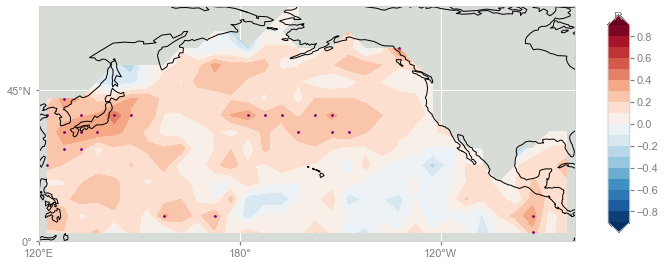

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['light grey']

fig = plt.figure(figsize=[12, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))

# map
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()

transform = ccrs.PlateCarree()
latlon_range = (120, 280, 0, 70)
lon_min, lon_max, lat_min, lat_max = latlon_range
lon_ticks = [60, 120, 180, 240, 300]
lat_ticks = [-90, -45, 0, 45, 90]

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=transform)
ax.set_yticks(lat_ticks[mask_lat], crs=transform)

# contour
clevs = np.linspace(-0.9, 0.9, 19)
#corr_r, lon_r = rotate_lon(corr.T, lon)  # rotate the field to make longitude in increasing order and convert to range (0, 360)
im = ax.contourf(ds_sel.longitude, ds_sel.latitude, corr.T, clevs, transform=transform, cmap='RdBu_r', extend='both')

# significant points
plt.scatter(x=slon, y=slat, color="purple", s=3,
            alpha=1,
            transform=transform) 


# colorbar
cbar_pad = 0.05
cbar_orientation = 'vertical'
cbar_aspect = 10
cbar_fraction = 0.15
cbar_shrink = 0.5
cbar_title = 'R'
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
                    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title(cbar_title)

The purple dots on the map are the locations of the gridpoints where the p-values fall under 5%, and they naturally correspond to the regions of highest correlations, though (and this is suspicious) they are rather randomly scattered across the domain.  
We might be tempted to declare victory and hail them as "significant", but not so fast! 
Our correlation test, nifty though it is, isn't infallible. In fact, conducting tests at the 5% level (what most people would call "the 95% confidence level") specifically means that we expect 5% of our tests to return spurious results, just from chance alone (the so-called "type I error"). We just carried out $n_t$ tests, so we expect $0.05*n_t \approx 16 $ of those results to be false positives, right out of the gate.  Which ones can we trust?

One way to approach this is to rank order the p-values of all 327 tests and plot them as in Hu et al (2017), Fig 2.

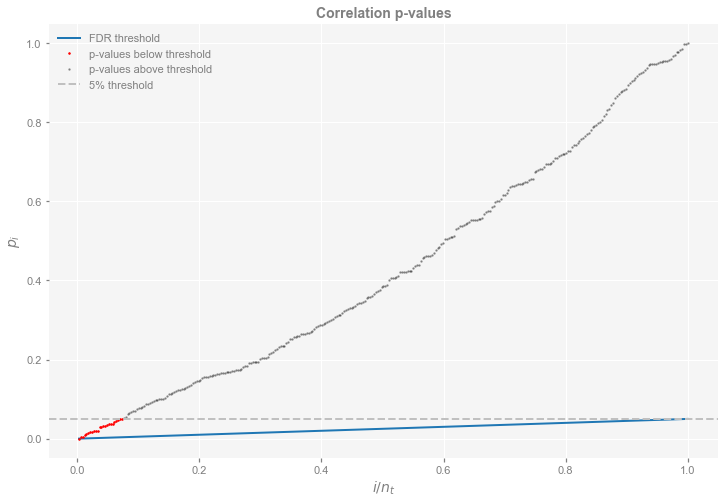

In [22]:
#check i/m vs. p-values
indexm = np.arange(1,nt+1,1)
im = 1.0*indexm / nt
thres = 0.05*im
pvec_s = sorted(pvec)
smaller=[]
small_index=[]
larger=[]
large_index=[]

n=0
for pp in pvec_s:
    if pp <=0.05:
        smaller.append(pp)
        small_index.append(im[n])
    else:
        larger.append(pp)
        large_index.append(im[n])
    n=n+1

f, ax = plt.subplots(figsize=(12,8))
plt.plot(im,thres,label='FDR threshold')
plt.plot(small_index,smaller,'ro',markersize=1.5,label='p-values below threshold')
plt.plot(large_index,larger,'ko',markersize=1.5,label='p-values above threshold',alpha=0.3)
plt.axhline(y=0.05,linestyle='dashed',color='silver',label='5% threshold')
plt.xlabel(r'$i/n_t$',fontsize=14)
plt.ylabel(r'$p_i$',fontsize=14)
plt.title('Correlation p-values',fontsize=14, fontweight='bold')
plt.legend()

One solution to this is the False Discovery Rate (aka **FDR**), which was devised in a celebrated 1995 paper [(Benjamini & Hochberg, 1995)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x). The idea is to look not just for the p-values under 5% (red dots in the figure above), but for the fraction of those under the blue line, which guards against the false discoveries one expects out of repeatedly testing the same hypothesis over and over again. Luckily for you, we have this coded up in `pyleoclim` (you knew we would). One way to access it is thus:

In [23]:
fdr_res = pyleo.utils.correlation.fdr(pvec_s)
print(fdr_res)

None


And with this treatment, exactly 0 gridpoints pass the test. 

**Exercise 5.3** redo this with other correlation methods and see if the results change. A little patience is required for the other two methods, which loop over surrogates. We suggest using a moderate number of simulations (`nsim` < 500) to do so; please check the documentation of `corr_sig` for how to reduce this number, which is 1000 by default.  

In [24]:
pval2 = np.empty((nlon,nlat)) # declare array to store pvalues
corr2 = np.empty_like(pval) # declare empty array of identical shape
slon, slat = [], [];
sst_list = [] # initialize empty list 

for ji in range(nlon):
    print("Computing correlations at " + str(ds_sel.longitude[ji].values) + 'E')
    for jj in range(nlat):  
        st = ds_sel['tos'][:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        st_annual = anomalies.groupby("time.year").mean("time")
        #  test if at least 100 non-NaNs
        noNaNs = len(np.where(np.isnan(st_annual) == False)[0]) # number of valid years
        sstvar = st_annual.var()
        if noNaNs >= 100 and sstvar >= 0.01:
            sttb = pyleo.Series(time=st_annual.coords['year'].values,
                        time_unit ='year CE', 
                        value=st_annual.values,
                        value_unit = 'C')
            sst_list.append(sttb) 
            corr_res = sttb.correlation(cc, settings={'method':'isospectral','nsim':1000},seed=333)
            pval2[ji,jj] = corr_res.p
            corr2[ji,jj] = corr_res.r
            if pval2[ji,jj] < alpha:
                slon.append(ds_sel.longitude[ji])
                slat.append(ds_sel.latitude[jj])
        else:  
            pval2[ji,jj] = np.nan; corr2[ji,jj] = np.nan

Computing correlations at 122.5E
Computing correlations at 127.5E
Computing correlations at 132.5E
Computing correlations at 137.5E
Computing correlations at 142.5E
Computing correlations at 147.5E
Computing correlations at 152.5E
Computing correlations at 157.5E
Computing correlations at 162.5E
Computing correlations at 167.5E
Computing correlations at 172.5E
Computing correlations at 177.5E
Computing correlations at 182.5E
Computing correlations at 187.5E
Computing correlations at 192.5E
Computing correlations at 197.5E
Computing correlations at 202.5E
Computing correlations at 207.5E
Computing correlations at 212.5E
Computing correlations at 217.5E
Computing correlations at 222.5E
Computing correlations at 227.5E
Computing correlations at 232.5E
Computing correlations at 237.5E
Computing correlations at 242.5E
Computing correlations at 247.5E
Computing correlations at 252.5E
Computing correlations at 257.5E
Computing correlations at 262.5E
Computing correlations at 267.5E
Computing 

In [25]:
pvals2 = pval2.flatten() # make the p-value array a 1D one
pvec2 = pvals2[pvals2<1] # restrict to valid probabilities as there are a few weird values.
fdr_res2 = pyleo.utils.correlation.fdr(sorted(pvec2))
print(fdr_res2)

[0]


Again, only 1 grid point emerges as significant with this method. Now, another way we could have done this is to bundle all SST series from each grid point as a MultipleSeries object, and let the `CorrEns` class do its magic. This allows to directly compute the correlation between objects, and leverage the [CorrEns class](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#correns-pyleoclim-correns) and its plotting method:

100%|████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:30<00:00, 10.85it/s]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

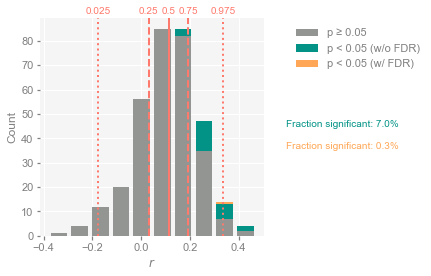

In [26]:
sstMS = pyleo.MultipleSeries(sst_list)
corr_ens = sstMS.correlation(cc,settings={'method':'isospectral','nsim':1000},seed=333)   
corr_ens.plot()

In [27]:
corr_ens.signif_fdr.count(True)

1

We find the same result as before, but wouldn't you say this is more elegant? Note, however, that this method does not keep track of where the significant points are (it does not have a notion of what "where" means), so if you wanted to draw a map like the one above, this would not be a helpful tool. 


## Pitfall #3: Age uncertainties

As if the first two pitfalls weren't enough, there is a third difficulty in this comparison: beautiful though U/Th chronologies may be, they are not perfect (do not believe people who tell you otherwise!). Such chronological uncertainties must be taken into account as well. 

It turns out that the LiPD file loaded above contains not only the raw U/Th dates (dig for them if you're curious), but also an ensemble of age-depth relationships derived from those dates, via the Bayesian age model [BChron](https://cran.r-project.org/web/packages/Bchron/vignettes/Bchron.html). Let us load those 1000 draws from the posterior distribution of ages and put them in a place where `pyleoclim` will be able to work with them:

In [28]:
cc_ens = cc.chronEnsembleToPaleo(d)

There are two ways to plot this ensemble. First, as a series of traces:

<AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>

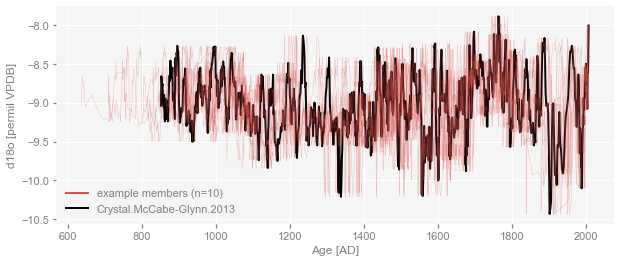

In [29]:
fig, ax = cc_ens.plot_traces()
cc.plot(color='black', ax = ax)

It is quite plain that any of the record's main swings can be swung back and forth by up to decades. Another way to see this is to plot various quantiles as an envelope:

<AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>

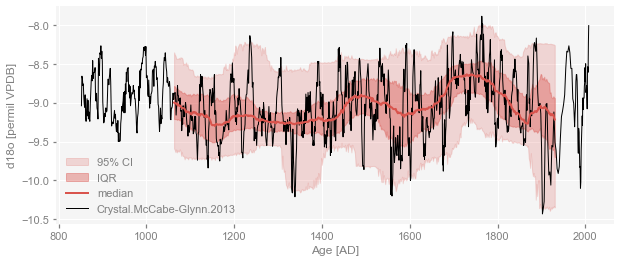

In [30]:
fig, ax = cc_ens.common_time(method='interp').plot_envelope(ylabel = cc.value_name)
cc.plot(color='black', ax = ax, linewidth=1)

Notice how the quantiles are computed over only part of the interval covered by the original series; that is because some age models end up being more compressed or stretched out than the original, and we need a common interval to compute quantiles. In particular, notice how the base of the record could really be anywhere between 850 and 1100 AD.

Now, what we'd like to do is repeat the exercise of Part 1, correlating the same SST timeseries from 32.5N 142.5W (near the Kuroshio Extension), not just with the published chronology, but this whole ensemble. Remember how we had computed things:

In [31]:
corr_res = stts.correlation(cc)
print(corr_res.r)

0.32422714913422396


Though of course, we could have done just the reverse, as correlation is a symmetric operator:

In [32]:
corr_res = cc.correlation(stts)
print(corr_res.r)

0.32422714913422396


Now, consider the task ahead: you must iterate over all ensemble members, taking care of aligning their time axis to that of HadSST4; you must compute the correlation and establish its significance with a sensible test (say, Ebisuzaki's isospectral test, see Pitfall #1), you need watch out for test multiplicity (see Pitfall #2) _and_  you need to visualize the results in an intuitive way. Don't you wish this has all been conveniently coded for you?



![Your wish](https://am23.mediaite.com/tms/cnt/uploads/2020/12/Life-Is-Good-but-It-Can-Be-Better-With-These-Max-Lord-Memes.jpg)


YOUR WISH HAS BEEN GRANTED!!!

To keep computing time manageable, let's reduce the number of isospectral simulations to 500, and correlate the ensemble and the SST series we started with:

In [38]:
nsim = 500
corr_Kuroshio = cc_ens.correlation(stts,settings={'nsim':nsim},seed = 453) 

100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:52<00:00, 19.11it/s]


Again `corr_Kuroshio` is a `CorrEns` object, which contains everything you want: the vector of correlations, the p-values, _and_ a method to plot them all:

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

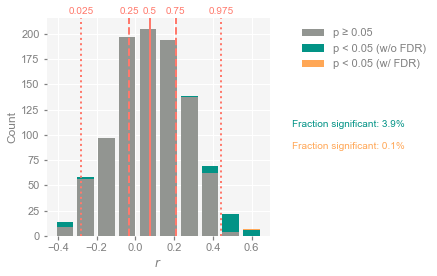

In [39]:
corr_Kuroshio.plot()

Several things jump out at once:
1. the correlation histogram is relatively symmetric, meaning that age uncertainties are able to completely overturn the original correlation of about 0.31 : nearly half of the ensemble exhibits negative correlations with SST).  0.31 (9% of common variance) is not a contender for winning the correlation olympics, but it was at least positive. Age uncertainties can easily reverse even the sign of that correlation.
1. As shown in teal, only ~4\% of the 500*100 correlations just computed are judged significant. 
1. Once we take test multiplicity into account via the False Discovery Rate (orange bar), only a fraction of a \%  is deemed significant. 

**Exercise 5.4** redo this at other locations and see if the results change. you may consider picking a patch of the North Pacific and applying this test recursively at each location. 

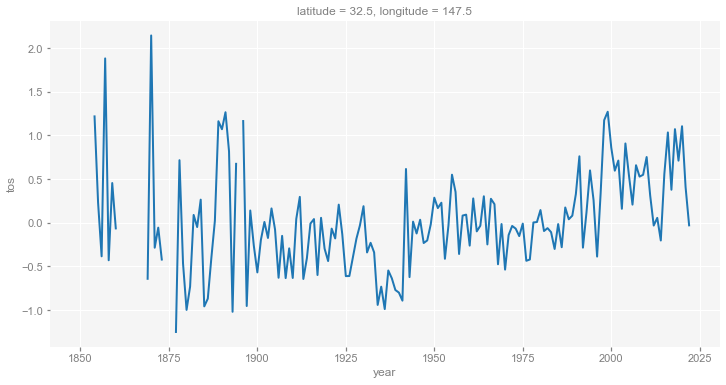

In [40]:
st = ds['tos'].sel(latitude=32.5, longitude = 147.5, method='nearest')  # pick a new location
climatology = st.groupby("time.month").mean("time")
anomalies = st.groupby("time.month") - climatology
st_annual = anomalies.groupby("time.year").mean("time")
st_annual.plot(figsize=[12, 6])

Put into a Series object, compute ensemble correlations, and plot:

100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:53<00:00, 18.79it/s]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

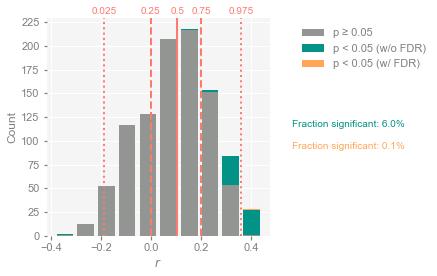

In [41]:
stts2 = pyleo.Series(time=st_annual.coords['year'].values,
                     time_unit ='year CE', 
                     value=st_annual.values,
                     value_unit = 'C')
corr_ens2 = cc_ens.correlation(stts2,settings={'nsim':nsim}) 
corr_ens2.plot()

## Conclusions


**Exercise 5.5**  To bring it all together, summarize everything that can go wrong when fishing for correlations (at sea, or on land). Can you think of other papers where correlations with paleoclimate records might have been used unwisely? (no names needed... Just keep that in mind in your own work and point people to more defensible ways of dealing with these pitfalls, e.g. Pyleoclim!) 

**Answer 5.5** The moral of the story is that all of these pitfalls matter ; any single of them can turn a correlation initially reported as "significant" into an insignificant one. That is especially the case with a conjunction of pitfalls, with any 2 out of 3. The conjunction of all 3 pitfalls (persistence, test multiplicity, and age uncertainties) is particularly damaging in this example. Fortunately, Pyleoclim makes it easy to deal with those pitfalls, so there is no excuse not to. 